### Visualising DC clusters only (re-doing from pre-hvg onwards instead of just re-mapping before calculating DEGs)
### Using bbknn for batch correction instead of harmony

In [1]:
#load packages I need
import os
import tools
import scanpy as sc
import pandas as pd
import dandelion as ddl
from tqdm import tqdm
import matplotlib.pyplot as plt
import scanpy.external as sce
from matplotlib.pyplot import rc_context
import seaborn as sns

In [2]:
#set current directory 
os.chdir('/scratch/user/s4436039/scdata/Myeloid_Objects')
os.getcwd()

'/scratch/user/s4436039/scdata/Myeloid_Objects'

In [3]:
# read in data
data_labels = sc.read_h5ad('NRclean_clustered2_DC.h5ad')
data_clean_prehvg = sc.read_h5ad('NR_cleandata.h5ad')

In [4]:
data_labels

AnnData object with n_obs × n_vars = 30241 × 1268
    obs: 'nCount_RNA', 'nFeature_RNA', 'sample_type', 'cancer_type', 'patient_id', 'sample_id', 'percent.mt', 'site', 'sample_type_major', 'cancer_subtype', 'integration_id', 'ident', 'dataset_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'S_score', 'G2M_score', 'keep_or_remove', 'leiden', 'celltype', 'leiden_DC', 'leiden_DC_v2', 'exclude_annots', 'leiden_M', 'Technology', 'cancer_type_broad', 'clean-leiden_0.8', 'clean-subcluster', 'clean-subcluster-v2', 'YS_sig', 'HSC_sig', 'CD5nDC2_up_vDC3', 'DC3_up_vCD5nDC2', 'CD5pDC2_up_vDC3', 'DC3_up_vCD5pDC2', 'DC3_up_vMono', 'Mono_up_vDC3', 'DC1_sig', 'DC2_sig', 'DC3_sig', 'DC_Axl_sig', 'DC2_up_DC3', 'DC3_up_DC2', 'mregDC_sig', 'cDC1_mregDC', 'cDC2_mregDC', 'NR_annotatio

In [5]:
data_clean_prehvg

AnnData object with n_obs × n_vars = 498382 × 15074
    obs: 'nCount_RNA', 'nFeature_RNA', 'sample_type', 'cancer_type', 'patient_id', 'sample_id', 'percent.mt', 'site', 'sample_type_major', 'cancer_subtype', 'integration_id', 'ident', 'dataset_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'S_score', 'G2M_score', 'keep_or_remove', 'leiden', 'celltype', 'leiden_DC', 'leiden_DC_v2', 'exclude_annots', 'leiden_M', 'Technology'
    var: 'name', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p'

In [28]:
#subset data_clean_prehvg to only the cells in data_labels based on barcode

# Get the list of barcodes (cell names) in data_labels
barcodes_to_keep = data_labels.obs.index

# subset data_clean_prehvg to just those in data_labels
data_clean_prehvg2 = data_clean_prehvg[data_clean_prehvg.obs.index.isin(barcodes_to_keep), :]

data_clean_prehvg2

View of AnnData object with n_obs × n_vars = 30241 × 15074
    obs: 'nCount_RNA', 'nFeature_RNA', 'sample_type', 'cancer_type', 'patient_id', 'sample_id', 'percent.mt', 'site', 'sample_type_major', 'cancer_subtype', 'integration_id', 'ident', 'dataset_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'S_score', 'G2M_score', 'keep_or_remove', 'leiden', 'celltype', 'leiden_DC', 'leiden_DC_v2', 'exclude_annots', 'leiden_M', 'Technology'
    var: 'name', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p'

In [29]:
# transfer metadata from final atlas (data_labels) to clean data pre-hvg (want pre-hvg data so I can re-do hvg calculation on just DC2)

#define columns to transfer
meta_columns = ['Technology','NR_annotations_simple','sample_type_major2','cancer_with_H','cancer_broadest','patient_treatment']

# Subset the metadata in data_labels to match data_clean_prehvg2's barcodes
metadata_to_transfer = data_labels.obs.loc[data_clean_prehvg2.obs.index, meta_columns]

# Add these columns to data_clean_prehvg2's obs
for col in meta_columns:
    data_clean_prehvg2.obs[col] = metadata_to_transfer[col]

# Verify that the metadata was transferred
data_clean_prehvg2.obs.tail()

/scratch/temp/14479333/ipykernel_274434/846974978.py:11: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


nCount_RNA  nFeature_RNA  \
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...   -9.995153     -8.131683   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...   -9.134331     -8.627023   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...  -10.033317     -7.518040   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...   -9.364501     -8.566583   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...   -9.738727     -7.459797   

                                                   sample_type cancer_type  \
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...      Adnexa       HGSOC   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...      Adnexa       HGSOC   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...      Adnexa       HGSOC   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...      Adnexa       HGSOC   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...      Adnexa       HGSOC   

                                                     patient_id  \
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...  Left Adnexa   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...  Left Adnexa   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...  Left Adnexa   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...  Left Adnexa   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...  Left Adnexa   

                                                                              sample_id  \
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...  SPECTRUM-OV-045_S1_CD45P_LEFT_OVARY   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...  SPECTRUM-OV-045_S1_CD45P_LEFT_OVARY   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...  SPECTRUM-OV-045_S1_CD45P_LEFT_OVARY   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...  SPECTRUM-OV-045_S1_CD45P_LEFT_OVARY   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...  SPECTRUM-OV-045_S1_CD45P_LEFT_OVARY   

                                                    percent.mt   site  \
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...      2694.0  ovary   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...       839.0  ovary   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...      1683.0  ovary   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...      2257.0  ovary   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...       949.0  ovary   

                                                   sample_type_major  \
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...    primary tumour   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...    primary tumour   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...    primary tumour   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...    primary tumour   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...    primary tumour   

                                                   cancer_subtype  ...  \
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...          HGSOC  ...   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...          HGSOC  ...   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...          HGSOC  ...   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...          HGSOC  ...   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...          HGSOC  ...   

                                                   leiden_DC leiden_DC_v2  \
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...         4            1   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...         2            4   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...         3            2   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...         5           15   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...         3            2   

                                                   exclude_annots  leiden_M  \
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...             NA       NaN   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...             NA       NaN   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...             NA       NaN   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...      

In [30]:
data_labels.obs["NR_annotations_simple"].value_counts()

NR_annotations_simple
cDC2      17391
cDC1       6730
mregDC     6120
Name: count, dtype: int64

In [31]:
# check
data_clean_prehvg2.obs["NR_annotations_simple"].value_counts()

NR_annotations_simple
cDC2      17391
cDC1       6730
mregDC     6120
Name: count, dtype: int64

In [32]:
# rename to data
data = data_clean_prehvg2

In [33]:
# check
data.obs["NR_annotations_simple"].value_counts()

NR_annotations_simple
cDC2      17391
cDC1       6730
mregDC     6120
Name: count, dtype: int64

# Filtering:

In [34]:
# remove any samples with less than 10 cells
data = data[data.obs['integration_id'].map(data.obs['integration_id'].value_counts()) >= 10].copy()

In [35]:
# remove any genes expressed in less than 10 cells
sc.pp.filter_genes(data, min_cells=10)

In [36]:
data

AnnData object with n_obs × n_vars = 29887 × 14529
    obs: 'nCount_RNA', 'nFeature_RNA', 'sample_type', 'cancer_type', 'patient_id', 'sample_id', 'percent.mt', 'site', 'sample_type_major', 'cancer_subtype', 'integration_id', 'ident', 'dataset_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'S_score', 'G2M_score', 'keep_or_remove', 'leiden', 'celltype', 'leiden_DC', 'leiden_DC_v2', 'exclude_annots', 'leiden_M', 'Technology', 'NR_annotations_simple', 'sample_type_major2', 'cancer_with_H', 'cancer_broadest', 'patient_treatment'
    var: 'name', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p'

# pre-hvg to integration on new DC2 only object:

In [37]:
# identify highly variable genes
sc.pp.highly_variable_genes(data, min_mean=0.0125, max_mean=3, min_disp=0.5)
data

AnnData object with n_obs × n_vars = 29887 × 14529
    obs: 'nCount_RNA', 'nFeature_RNA', 'sample_type', 'cancer_type', 'patient_id', 'sample_id', 'percent.mt', 'site', 'sample_type_major', 'cancer_subtype', 'integration_id', 'ident', 'dataset_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'S_score', 'G2M_score', 'keep_or_remove', 'leiden', 'celltype', 'leiden_DC', 'leiden_DC_v2', 'exclude_annots', 'leiden_M', 'Technology', 'NR_annotations_simple', 'sample_type_major2', 'cancer_with_H', 'cancer_broadest', 'patient_treatment'
    var: 'name', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [38]:
#set hidden slot
data.raw = data

In [39]:
#to get number of HV genes
print(data.var.highly_variable.sum())

1746


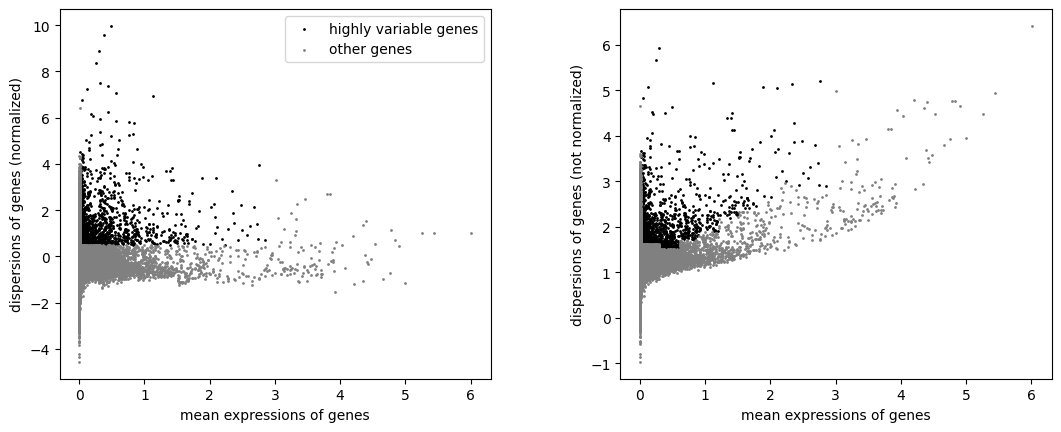

In [40]:
#plot out the number of highly variable genes
sc.pl.highly_variable_genes(data)

### regress out factors and perform scaling

In [41]:
# Actually do the filtering for PCA
data = data[
    :, data.var.highly_variable
].copy()  # all rows/indexes : columns only selecting for those within high_variable, and then making a copy of itself
data

AnnData object with n_obs × n_vars = 29887 × 1746
    obs: 'nCount_RNA', 'nFeature_RNA', 'sample_type', 'cancer_type', 'patient_id', 'sample_id', 'percent.mt', 'site', 'sample_type_major', 'cancer_subtype', 'integration_id', 'ident', 'dataset_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'S_score', 'G2M_score', 'keep_or_remove', 'leiden', 'celltype', 'leiden_DC', 'leiden_DC_v2', 'exclude_annots', 'leiden_M', 'Technology', 'NR_annotations_simple', 'sample_type_major2', 'cancer_with_H', 'cancer_broadest', 'patient_treatment'
    var: 'name', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [42]:
#Regress out total counts, %mt, cycling genes (30sec)
sc.pp.regress_out(data, ["total_counts", "pct_counts_mt", 'S_score', 'G2M_score'])
sc.pp.scale(data, max_value=10)

In [43]:
data

AnnData object with n_obs × n_vars = 29887 × 1746
    obs: 'nCount_RNA', 'nFeature_RNA', 'sample_type', 'cancer_type', 'patient_id', 'sample_id', 'percent.mt', 'site', 'sample_type_major', 'cancer_subtype', 'integration_id', 'ident', 'dataset_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'S_score', 'G2M_score', 'keep_or_remove', 'leiden', 'celltype', 'leiden_DC', 'leiden_DC_v2', 'exclude_annots', 'leiden_M', 'Technology', 'NR_annotations_simple', 'sample_type_major2', 'cancer_with_H', 'cancer_broadest', 'patient_treatment'
    var: 'name', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'l

### Perform PCA:

In [44]:
## perform PCA, adjust number of PCs to calculate. (1mins)
sc.pp.pca(data, n_comps=50)

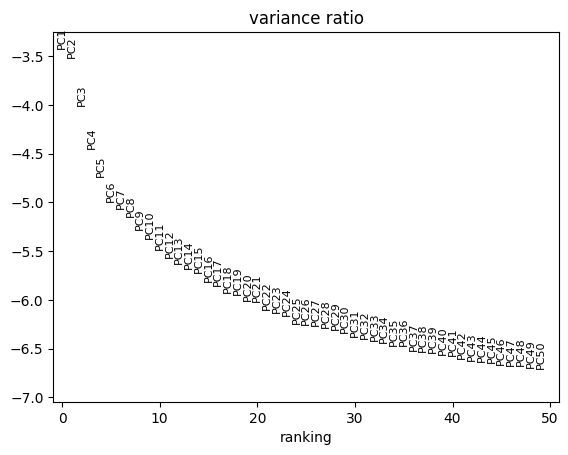

In [45]:
# make elbow plot to see variance contribution by each pc, choose inflection point
sc.pl.pca_variance_ratio(data, log=True, n_pcs=50)

### BBKNN Integration: 

In [24]:
sce.pp.bbknn(data, batch_key='integration_id')  

In [25]:
data.obsm

AxisArrays with keys: X_pca

#### No longer need neighbors step (bbknn replaces this)

### UMAP:

In [26]:
sc.tl.umap(data, min_dist=0.3) 

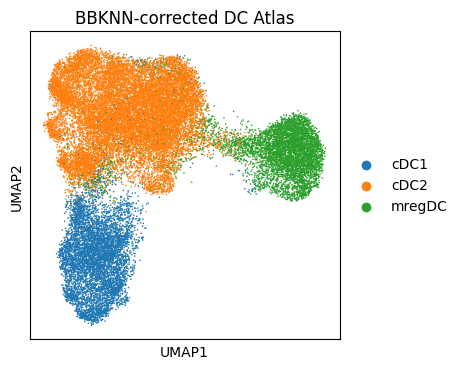

In [ ]:
#plotting DC map
with plt.rc_context({"figure.figsize": (4, 4)}):
    sc.pl.umap(data, color=["NR_annotations_simple"], ncols=1, size=5, title='BBKNN-corrected DC Atlas')

# Harmony Integration:

In [46]:
sce.pp.harmony_integrate(data, 'integration_id', max_iter_harmony=200, verbose=True)

2025-06-16 16:23:15,306 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-06-16 16:23:19,807 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-06-16 16:23:20,032 - harmonypy - INFO - Iteration 1 of 200
2025-06-16 16:24:55,256 - harmonypy - INFO - Iteration 2 of 200
2025-06-16 16:26:30,405 - harmonypy - INFO - Iteration 3 of 200
2025-06-16 16:27:59,866 - harmonypy - INFO - Iteration 4 of 200
2025-06-16 16:29:25,132 - harmonypy - INFO - Iteration 5 of 200
2025-06-16 16:30:51,110 - harmonypy - INFO - Iteration 6 of 200
2025-06-16 16:32:10,669 - harmonypy - INFO - Iteration 7 of 200
2025-06-16 16:33:35,932 - harmonypy - INFO - Iteration 8 of 200
2025-06-16 16:34:54,371 - harmonypy - INFO - Iteration 9 of 200
2025-06-16 16:36:11,601 - harmonypy - INFO - Iteration 10 of 200
2025-06-16 16:37:28,917 - harmonypy - INFO - Iteration 11 of 200
2025-06-16 16:38:46,053 - harmonypy - INFO - Converged after 11 iterations


In [47]:
data.obsm

AxisArrays with keys: X_pca, X_pca_harmony

In [48]:
#check made new column with adjusted harmony PCs
'X_pca_harmony' in data.obsm

True

In [49]:
#assign the new PCs to the standard PCA slot for post int
data.obsm['X_pca'] = data.obsm['X_pca_harmony']

In [51]:
## Computing neighbourhood graph - here UMAP
sc.pp.neighbors(data, n_neighbors=10, n_pcs=50)

In [52]:
sc.tl.umap(data, min_dist=0.3)  # 0.3 is personal preference

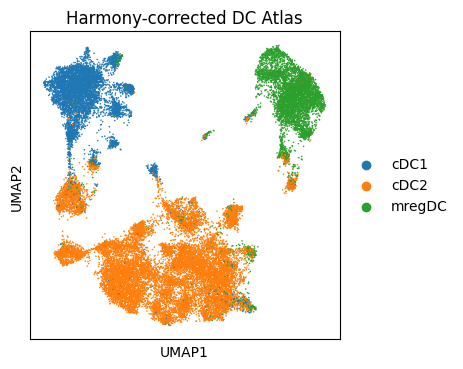

In [53]:
#plotting DC map
with plt.rc_context({"figure.figsize": (4, 4)}):
    sc.pl.umap(data, color=["NR_annotations_simple"], ncols=1, size=5, title='Harmony-corrected DC Atlas')

# Up to here:

### Overlay gene sets:

In [29]:
#define DC subset gene sets from Guimaraes et al and Cheng et al
DC2_FCER1A = ['CD1C', 'FCER1A', 'CLEC10A']
DC2_AREG = ['AREG']
DC2_CD207 = ['CD207','CD1A'] #same as DC2_CD1A in Cheng et al
DC3_CD14 = ['CD14', 'S100A9', 'S100A8', 'VCAN', 'LYZ']
DC4_FCGR3A = ['FCGR3A', 'FTL', 'SERPINA1']
DC_CXCL8 = ['CXCL2'] #CXCL8 removed as not in atlas 

DC2_CXCR4 = ['CXCR4']
DC2_IL1B = ['CD163','CD14','IL1B','TNF','CCL3','CCL4']
DC2_FCN1 = ['CD163', 'CD14', 'FCN1']
DC2_ISG15 = ['ISG15','IFIT1'] #IFIT6 removed as not in atlas
DC2_CXCL9 = ['CXCL9']

In [30]:
gene_sets_all = {
    "Guimaraes_DC2_FCER1A": DC2_FCER1A,
    "Guimaraes_DC2_AREG": DC2_AREG,
    "Guimaraes_Cheng_DC2_CD207/CD1A": DC2_CD207,
    "Guimaraes_DC3_CD14": DC3_CD14,
    "Guimaraes_DC4_FCGR3A": DC4_FCGR3A,
    "Guimaraes_DC_CXCL2": DC_CXCL8,
    "Cheng_DC2_CXCR4": DC2_CXCR4,
    "Cheng_DC2_IL1B": DC2_IL1B,
    "Cheng_DC2_FCN1": DC2_FCN1,
    "Cheng_DC2_ISG15": DC2_ISG15,
    "Cheng_DC2_CXCL9": DC2_CXCL9
}

In [31]:
# Loop through each gene set and calculate the scores
for name, genes in gene_sets_all.items():
    sc.tl.score_genes(data_DC2, genes, score_name=name)

In [32]:
colour_vars = ["Guimaraes_DC2_FCER1A","Guimaraes_DC2_AREG","Guimaraes_Cheng_DC2_CD207/CD1A","Guimaraes_DC3_CD14","Guimaraes_DC4_FCGR3A","Guimaraes_DC_CXCL2","Cheng_DC2_CXCR4","Cheng_DC2_IL1B","Cheng_DC2_FCN1","Cheng_DC2_ISG15","Cheng_DC2_CXCL9"]

In [33]:
sc.set_figure_params(dpi=80, dpi_save=700, vector_friendly=True, format='svg')

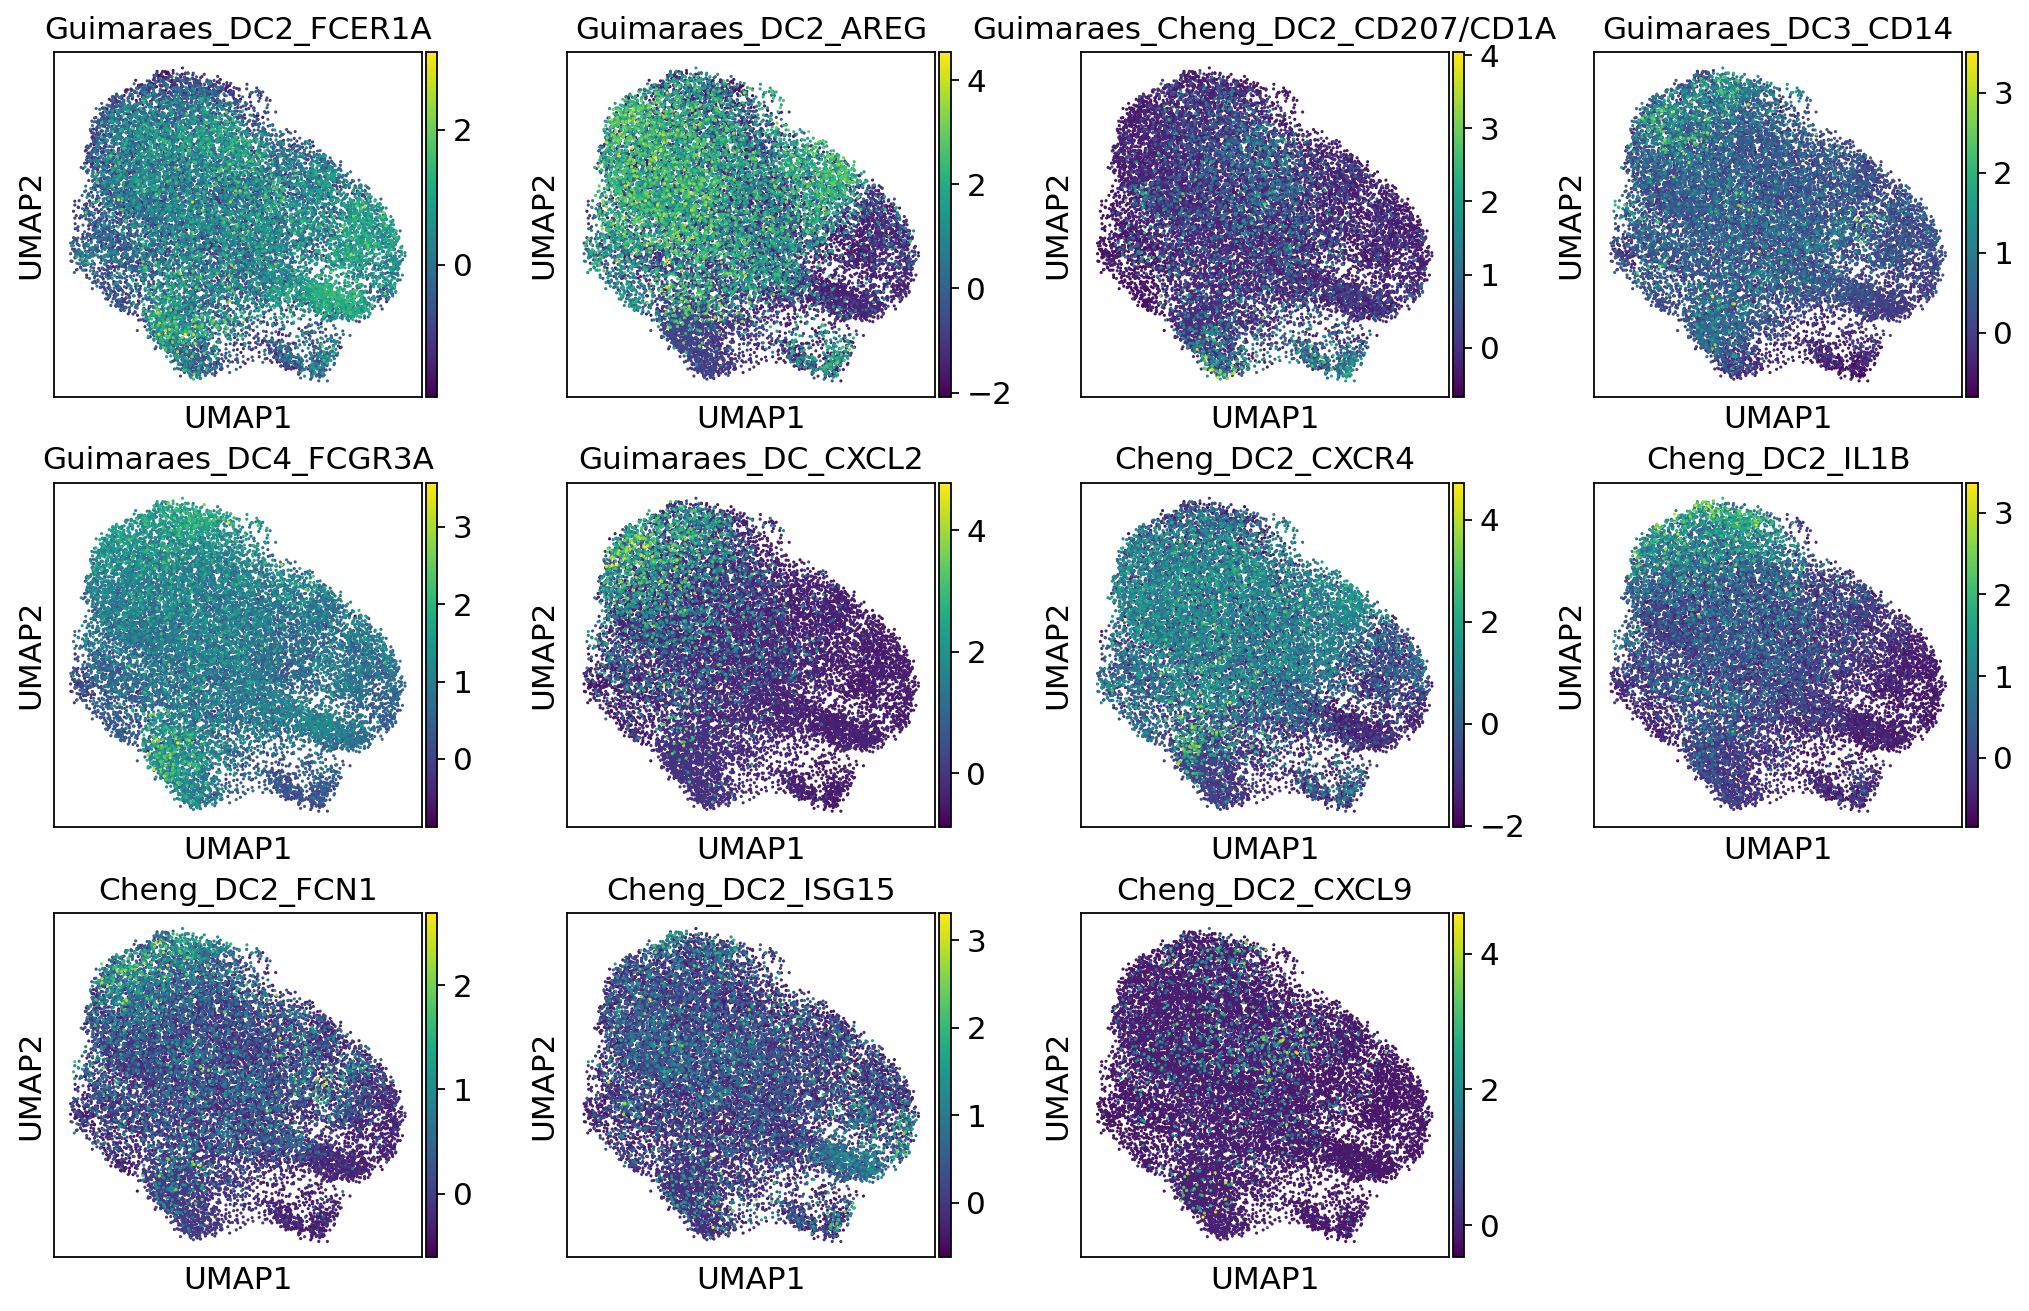

In [34]:
# plot:
with plt.rc_context({"figure.figsize": (3, 3)}):
    sc.pl.umap(data_DC2, color=colour_vars, ncols=4, size=8, 
    save="_DC2_sigs_overlay.svg")

In [40]:
# export object: 
data_DC2.write_h5ad("20250613_DC2_bbknn.h5ad", compression="gzip")

In [ ]:
data_DC2 = sc.read_h5ad('20250613_DC2_bbknn.h5ad')

## CLustering DC2 (40min):

In [41]:
# Update after updated parameters 
sc.tl.leiden(data_DC2, resolution=0.2, key_added='2025-DC2-true_02')
sc.tl.leiden(data_DC2, resolution=0.5, key_added='2025-DC2-true_05')
sc.tl.leiden(data_DC2, resolution=0.8, key_added='2025-DC2-true_08')

/scratch/temp/14461670/ipykernel_1715839/3641059270.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.


In [61]:
data_DC2.write_h5ad("20250613_DC2_bbknn_clustered.h5ad", compression="gzip")

In [42]:
colour_vars = ['2025-DC2-true_02', '2025-DC2-true_05', '2025-DC2-true_08']

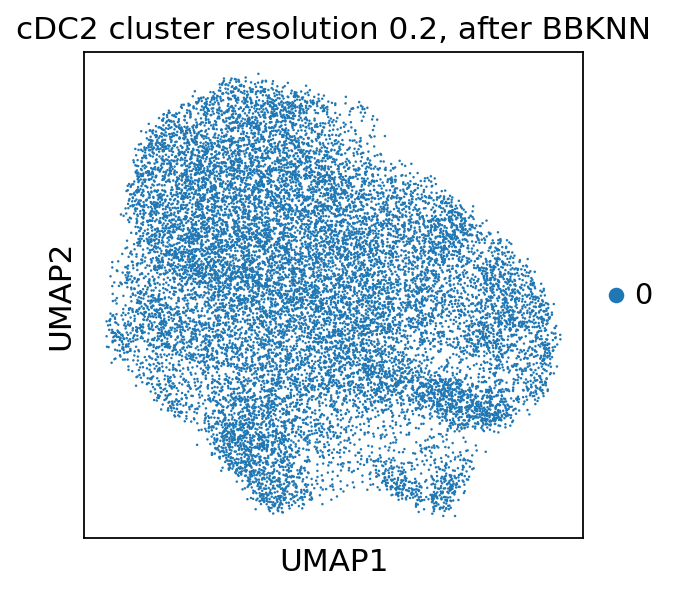

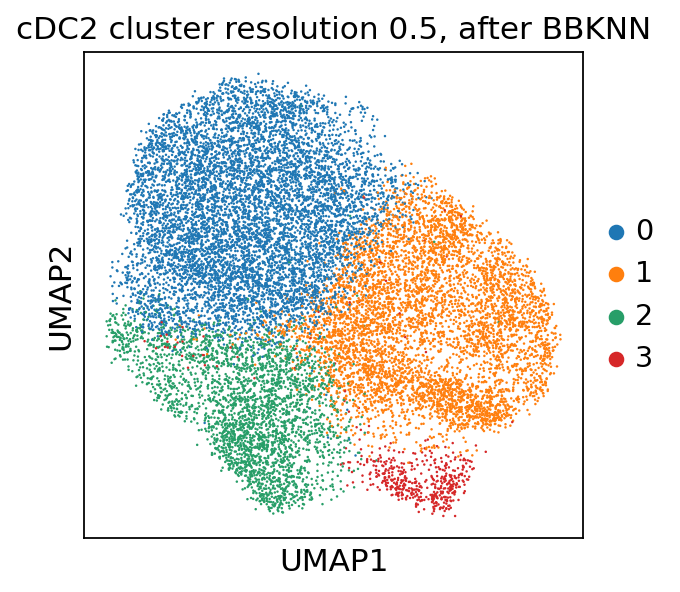

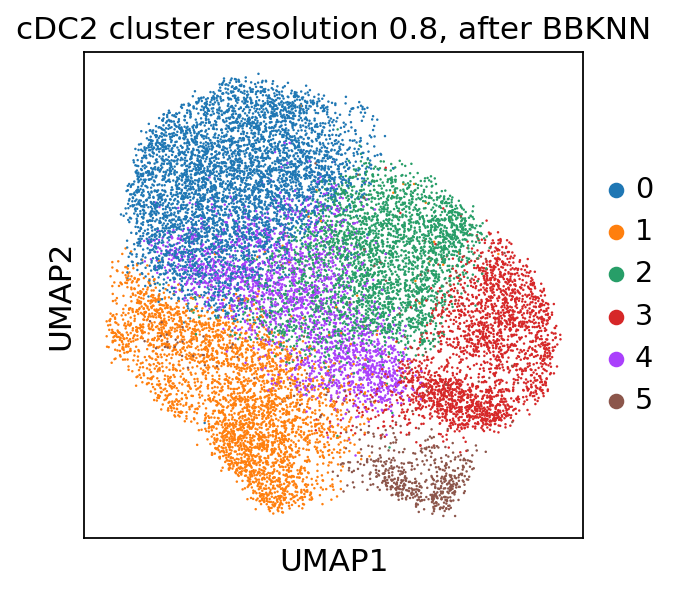

In [43]:
#plotting clusters 
with plt.rc_context({"figure.figsize": (4, 4)}):
    sc.pl.umap(data_DC2, color=["2025-DC2-true_02"], ncols = 1, size=5, title="cDC2 cluster resolution 0.2, after BBKNN")
    sc.pl.umap(data_DC2, color=["2025-DC2-true_05"], ncols = 1, size=5, title="cDC2 cluster resolution 0.5, after BBKNN")
    sc.pl.umap(data_DC2, color=["2025-DC2-true_08"], ncols = 1, size=5, title="cDC2 cluster resolution 0.8, after BBKNN")

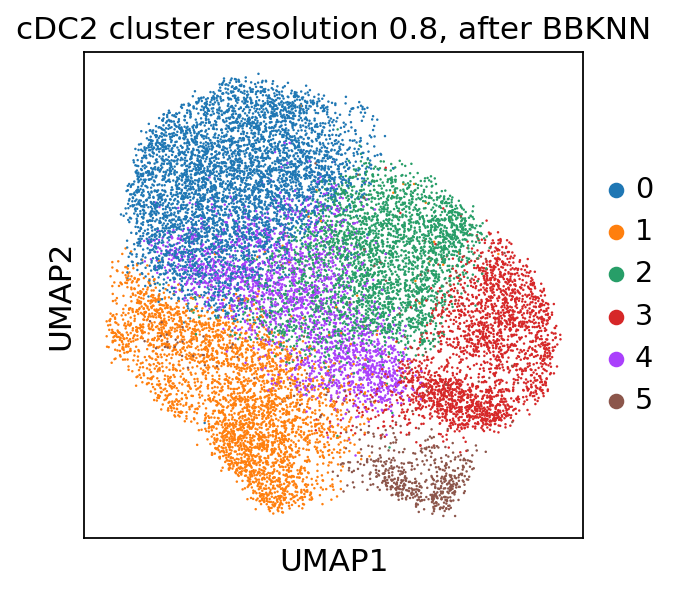

In [45]:
#plotting clusters 
with plt.rc_context({"figure.figsize": (4, 4)}):
    sc.pl.umap(data_DC2, color=["2025-DC2-true_08"], ncols = 1, size=5, title="cDC2 cluster resolution 0.8, after BBKNN", save="_DC2_subcluster.svg")

In [46]:
#output the number of cells in each cluster
data_DC2.obs["2025-DC2-true_08"].value_counts()

2025-DC2-true_08
0    4914
1    3284
2    3078
3    2400
4    2345
5     622
Name: count, dtype: int64

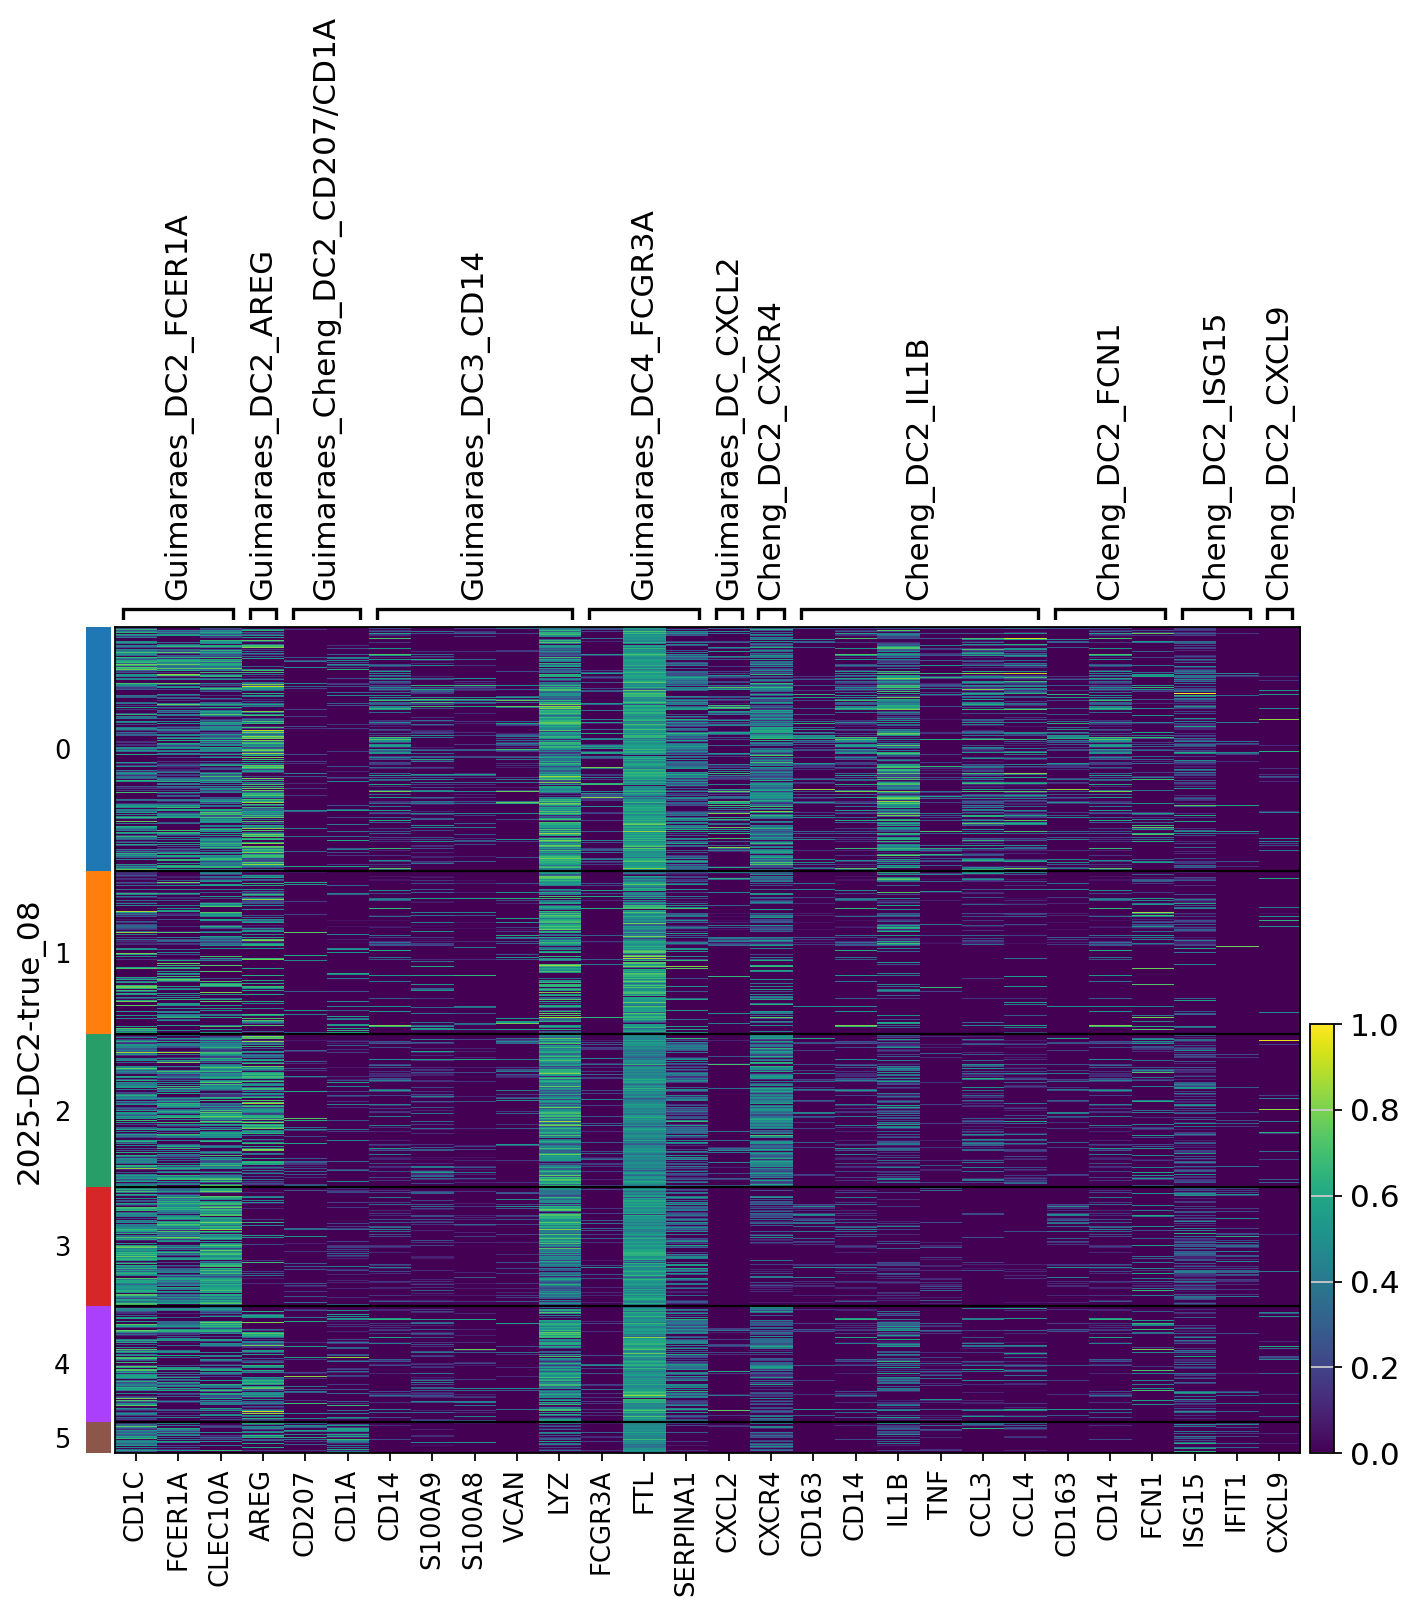

In [54]:
sc.pl.heatmap(data_DC2, gene_sets_all, groupby="2025-DC2-true_08", standard_scale="var", figsize=(10,7), save="_DC2_subcluster_sigs.svg") 

## Breakdown of clusters:

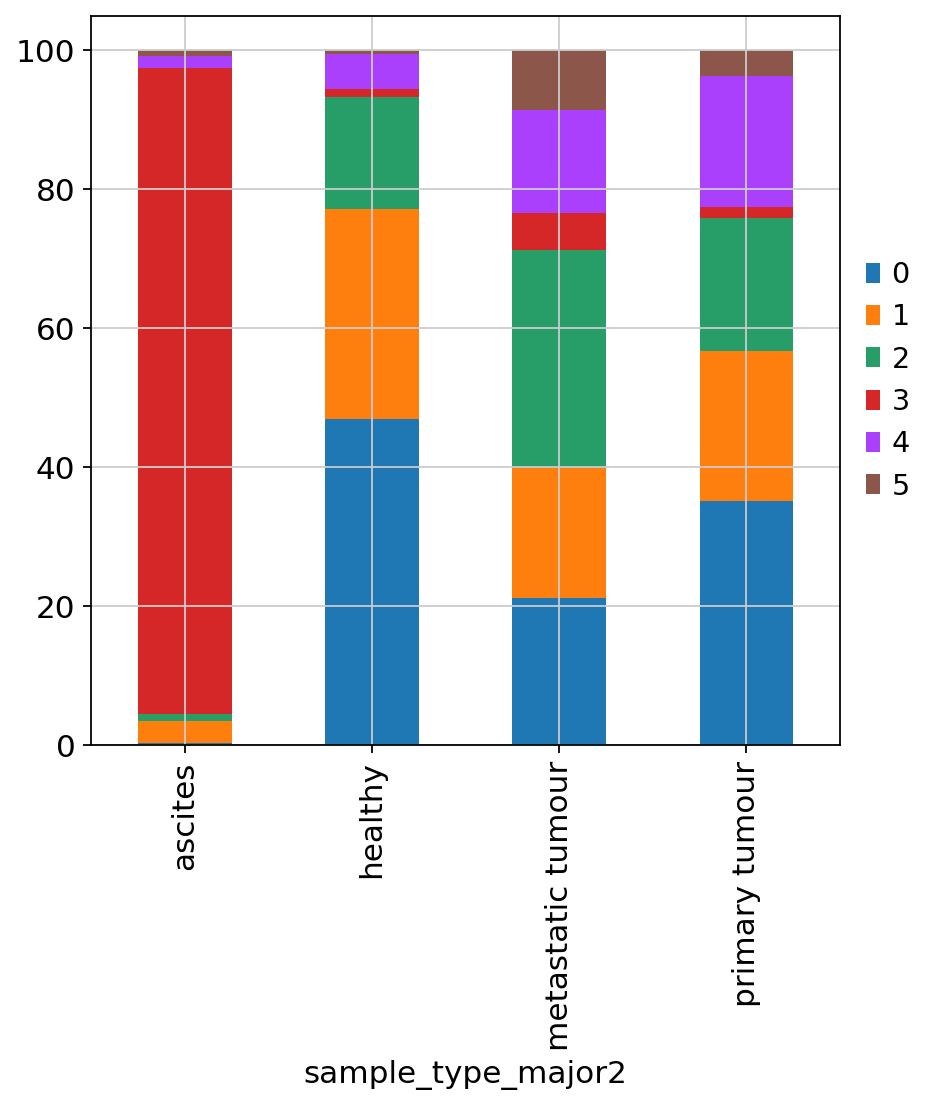

In [55]:
pd.crosstab(data_DC2.obs["sample_type_major2"], data_DC2.obs["2025-DC2-true_08"]).apply(
    lambda r: r / r.sum() * 100, axis=1
).plot.bar(stacked=True, figsize=(6,6))
plt.legend(bbox_to_anchor=(1, 0.5), loc="center left", frameon=False)
plt.show()

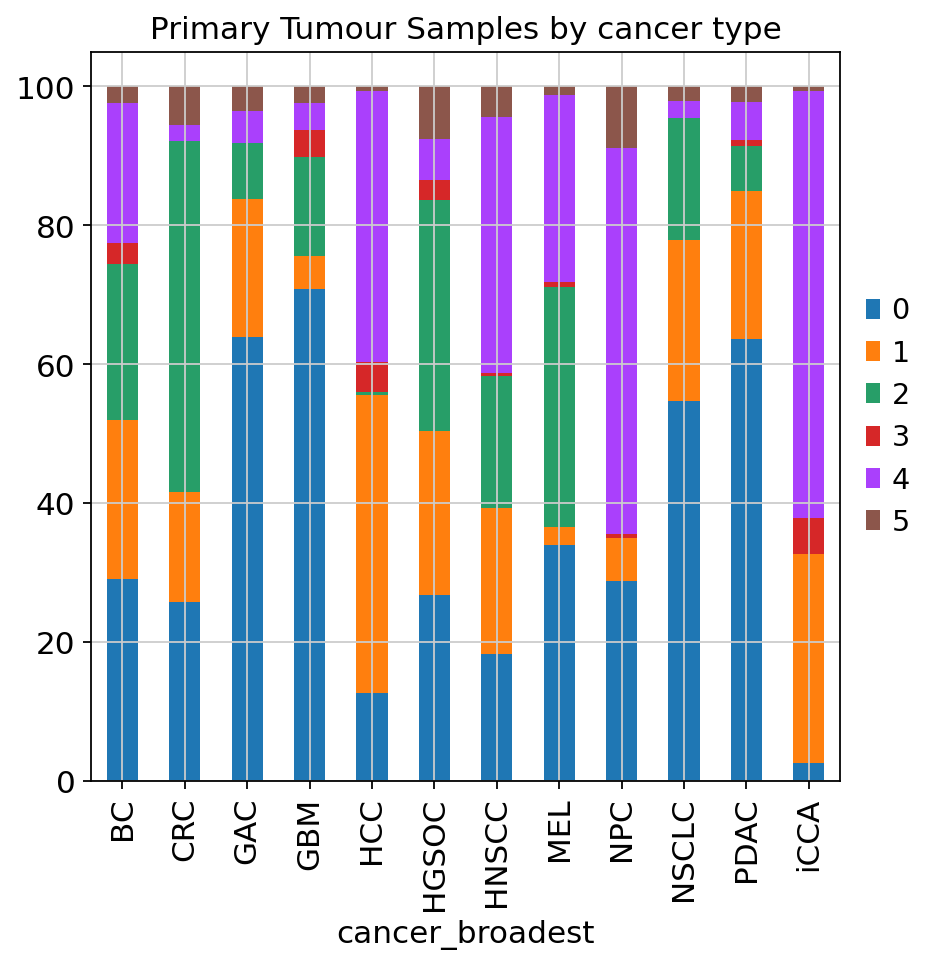

In [60]:
# subset to just primary
data_DC2_P = data_DC2[data_DC2.obs["sample_type_major2"] == "primary tumour"]

pd.crosstab(data_DC2_P.obs["cancer_broadest"], data_DC2_P.obs["2025-DC2-true_08"]).apply(
    lambda r: r / r.sum() * 100, axis=1
).plot.bar(stacked=True, figsize=(6,6))
plt.legend(bbox_to_anchor=(1, 0.5), loc="center left", frameon=False)
plt.title("Primary Tumour Samples by cancer type"),
plt.show()

### Checking Villani DC3 sig

In [35]:
DC3_sig = ['S100A9','S100A8','VCAN','LYZ','ANXA1','PLBD1','RNASE2','FCER1A','SLC2A3','CD163','CSF3R','MNDA','CD14','NAIP','CSTA','FCN1','CD1D','FPR1','F13A1','CLEC10A','CES1','PID1','S100A12','MTMR11','SMA','LAT2','RETN','TMEM173','AOAH','RAB3D','CD36','MGST1','TREM1','HNMT','CES1P1','ADAM15','IL13RA1','MICAL2','ITGA5','CREB5','IL1B','NR4A2','MPP7','PTAFR','HBEGF','NFE2','ASGR1','BST1','IL1RN','NOD2','NLRP3','DQ575504','LMNA','C9ORF89','IL27RA','NLRP12','RAB27A','EREG','LOC284454']

In [36]:
# Define dictionary of gene sets
gene_sets = {
    "DC3_sig": DC3_sig
}

In [37]:
# Loop through each gene set and calculate the scores
for name, genes in gene_sets.items():
    sc.tl.score_genes(data_DC2, genes, score_name=name)

In [38]:
colour_vars = ["DC3_sig"]

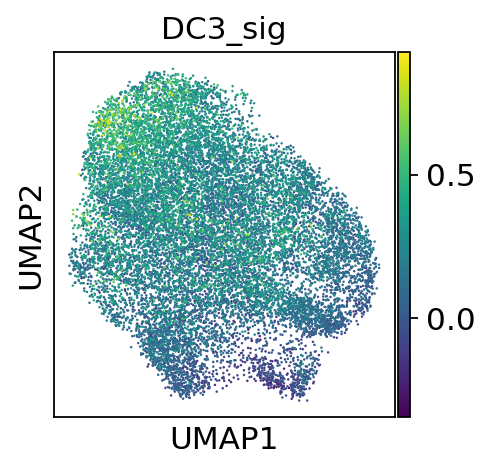

In [39]:
#plotting 
with plt.rc_context({"figure.figsize": (3, 3)}):
    sc.pl.umap(data_DC2, color=colour_vars, ncols=3, size=5)